In [288]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind as ttest
from scipy.stats import kstest
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Гипотезы
1. Продолжительность полета отрицательно влияет на удовлетоворенность клиентов.
2. Гендерная принадлежность в среднем не влияет на удовлетворенность клиента полетом.
3. Лояльные клиенты чаще ставят высокие оценки и остаются удовлетворены полетом в целом.
4. Пассажиры бизнес-класса чаще остаются удовлетворены полетом.
5. Взрослые пассажиры чаще бывают недовольны полетом, чем молодые.
6. Удобство кресла и развлечения в полете положительно влияют на удовлеторенность полетом.

In [122]:
df = pd.read_csv('Invistico_Airline.csv')

In [123]:
df.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


Датасет состоит из 129880 строк и 23 столбцов.

In [124]:
df.shape

(129880, 23)

Пропущенные значения есть только в переменной 'Arrival Delay', их всего 393.

In [125]:
df.isna().sum()

satisfaction                           0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

В датасете 18 количественных переменных и 5 категориальных.

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

Для удобства поменяем названия переменных.

In [127]:
df.columns = ['satisfaction', 'gender', 'customer_type', 'age', 'travel_type', 'class_type', 'distance', 'seat_comfort', 'time_conv', 'food', 'gate_loc', 'wifi', 'entertainment', 'online_support', 'easy_online_booking', 'onboard_service', 'leg_room', 'baggage', 'checkin', 'clean', 'online_boarding', 'dep_delay', 'arr_delay'] 

Посмотрим на значения категориальных переменных.

In [128]:
for i in ['satisfaction', 'gender', 'customer_type', 'travel_type', 'class_type']:
    print(i)
    print(df[i].unique())
    print()

satisfaction
['satisfied' 'dissatisfied']

gender
['Female' 'Male']

customer_type
['Loyal Customer' 'disloyal Customer']

travel_type
['Personal Travel' 'Business travel']

class_type
['Eco' 'Business' 'Eco Plus']



Удалим строки с пропущенными значениями и переведем переменную 'arr_delay' к целочисленному типу. Перекодируем категориальные переменные в числовой формат.

In [129]:
df.dropna(inplace=True)
df.arr_delay = df.arr_delay.astype(int)

df.satisfaction = df.satisfaction.apply(lambda x: 1 if x == 'satisfied' else 0)
df.gender = df.gender.apply(lambda x: 1 if x == 'Male' else 0)
df.customer_type = df.customer_type.apply(lambda x: 1 if x == 'Loyal Customer' else 0)
df.travel_type = df.travel_type.apply(lambda x: 1 if x == 'Business travel' else 0)

def set_class_type(x):
    if x == 'Eco':
        return 0
    if x == 'Eco Plus':
        return 1
    else:
        return 2
    
df.class_type = df.class_type.apply(set_class_type)

Выведем описательную статистику переменных.

In [134]:
df.describe().round(2).iloc[:, :13]

,satisfaction,gender,customer_type,age,travel_type,class_type,distance,seat_comfort,time_conv,food,gate_loc,wifi,entertainment
count,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00
mean,0.55,0.49,0.82,39.43,0.69,1.03,1981.01,2.84,2.99,2.85,2.99,3.25,3.38
std,0.50,0.50,0.39,15.12,0.46,0.96,1026.88,1.39,1.53,1.44,1.31,1.32,1.35
min,0.00,0.00,0.00,7.00,0.00,0.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,27.00,0.00,0.00,1359.00,2.00,2.00,2.00,2.00,2.00,2.00
50%,1.00,0.00,1.00,40.00,1.00,1.00,1924.00,3.00,3.00,3.00,3.00,3.00,4.00
75%,1.00,1.00,1.00,51.00,1.00,2.00,2543.00,4.00,4.00,4.00,4.00,4.00,4.00
max,1.00,1.00,1.00,85.00,1.00,2.00,6951.00,5.00,5.00,5.00,5.00,5.00,5.00


In [135]:
df.describe().round(2).iloc[:, 13:]

,online_support,easy_online_booking,onboard_service,leg_room,baggage,checkin,clean,online_boarding,dep_delay,arr_delay
count,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00,129487.00
mean,3.52,3.47,3.47,3.49,3.70,3.34,3.71,3.35,14.64,15.09
std,1.31,1.31,1.27,1.29,1.16,1.26,1.15,1.30,37.93,38.47
min,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,2.00,3.00,2.00,3.00,3.00,3.00,2.00,0.00,0.00
50%,4.00,4.00,4.00,4.00,4.00,3.00,4.00,4.00,0.00,0.00
75%,5.00,5.00,4.00,5.00,5.00,4.00,5.00,4.00,12.00,13.00
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1592.00,1584.00


Посмотрим распределения всех переменных в датасете.

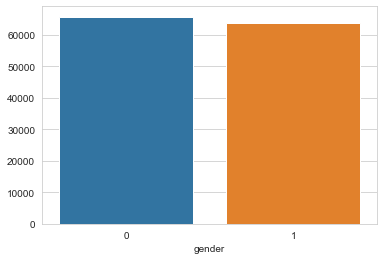

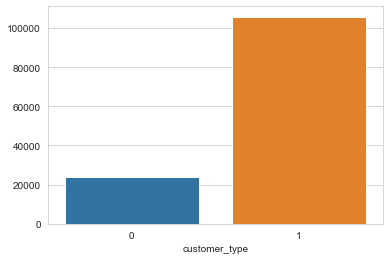

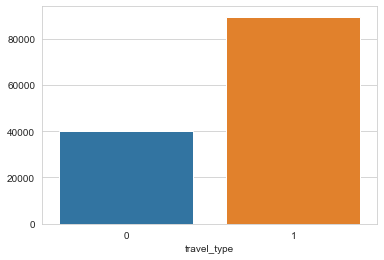

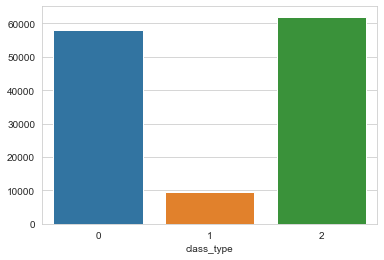

In [132]:
for i in df.columns[(df.max() < 5)].drop(labels='satisfaction'):
    temp = df.groupby(i).satisfaction.count()
    x, y = temp.index, temp.values
    
    sns.barplot(x=x, y=y)
    plt.show()

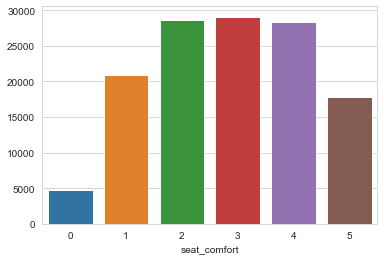

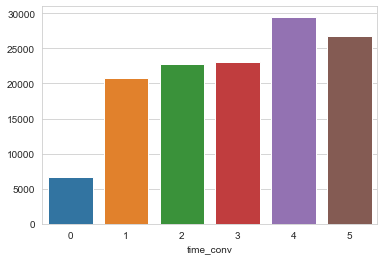

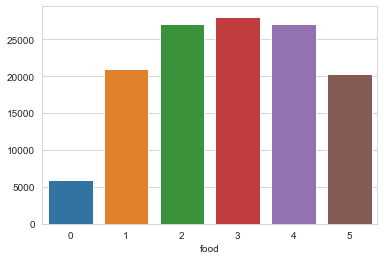

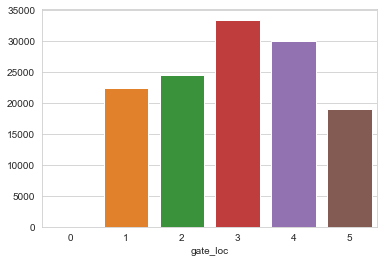

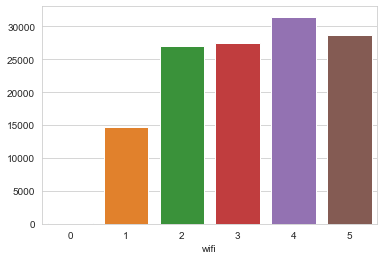

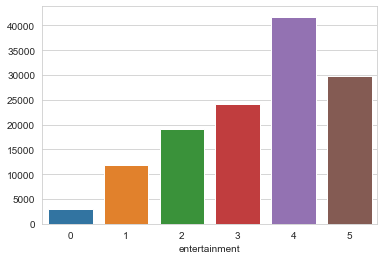

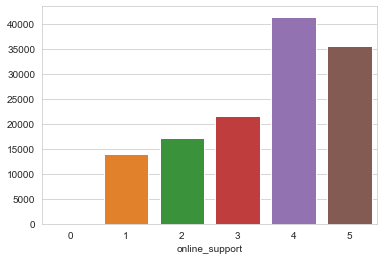

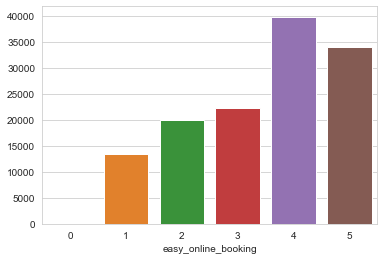

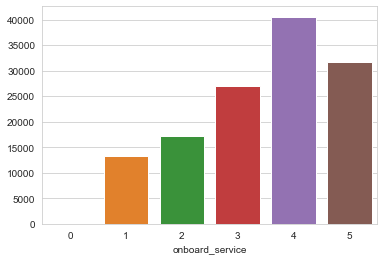

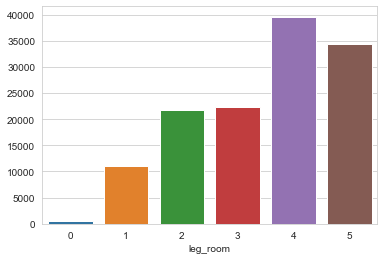

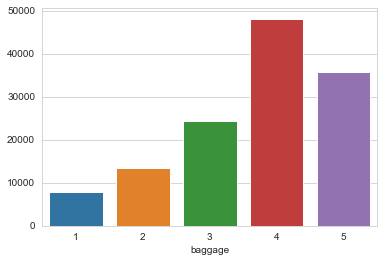

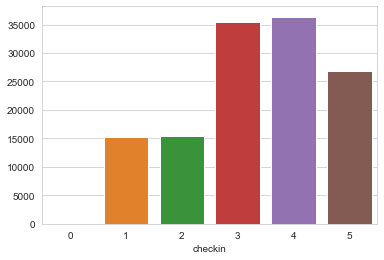

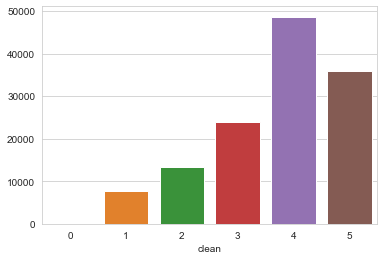

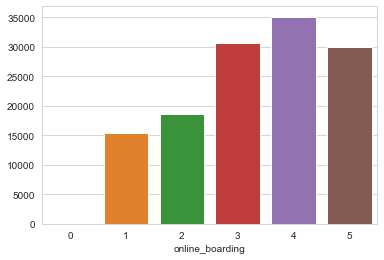

In [30]:
for i in df.columns[(df.max() == 5)]:
    temp = df.groupby(i).satisfaction.count()
    x, y = temp.index, temp.values
    
    sns.barplot(x=x, y=y)
    plt.show()

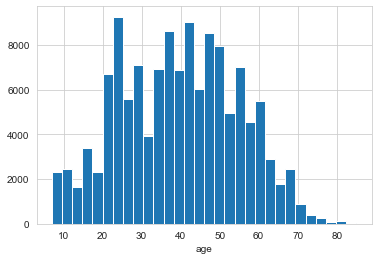

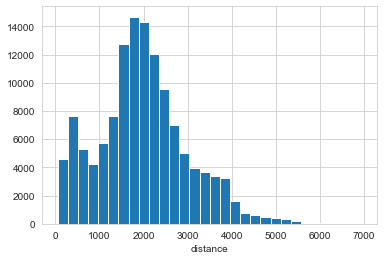

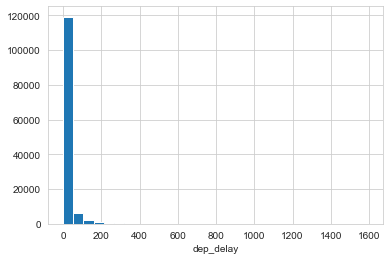

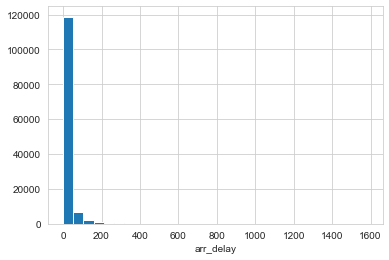

In [137]:
for i in df.columns[(df.max() > 5)]:
    plt.hist(df[i], bins=30)
    plt.xlabel(i)
    plt.show()

Возьмем логарифм от задержки отправления и прибытия, а затем посмотрим насколько распределения близки к нормальным.

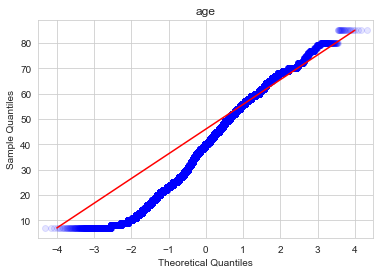

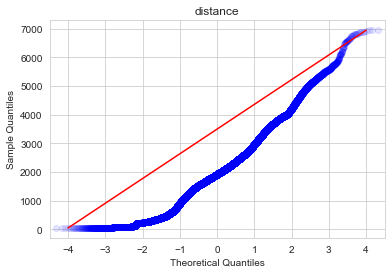

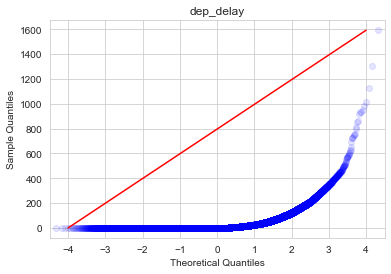

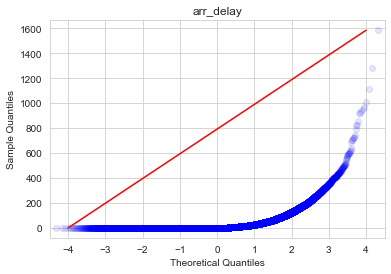

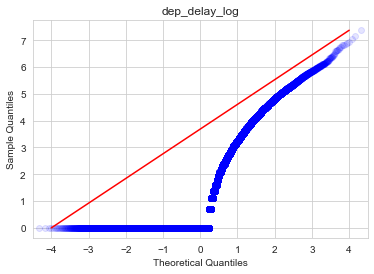

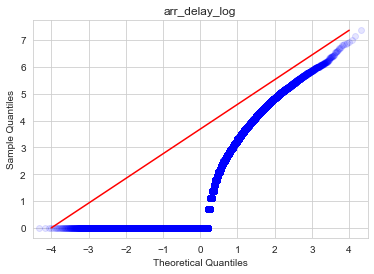

In [144]:
df['dep_delay_log'] = df.dep_delay.apply(lambda x: 0 if x == 0 else np.log(x))
df['arr_delay_log'] = df.arr_delay.apply(lambda x: 0 if x == 0 else np.log(x))

for i in df.columns[(df.max() > 5)]:
    qqplot(df[i], alpha=0.1)
    plt.plot([-4, 4], [df[i].min(), df[i].max()], color='red')
    plt.title(i)
    plt.show()

К нормальному близко только распределение возраста. Логарифмирование помогло лишь немного приблизить распределение переменных к нормальному.

Посмотрим среднее значение целевой метрики в зависимости от значения других переменных.

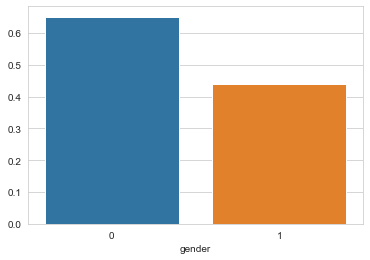

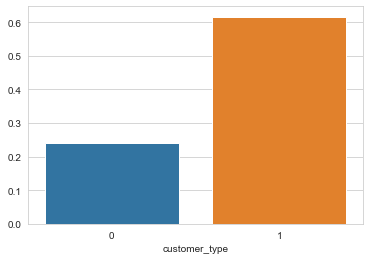

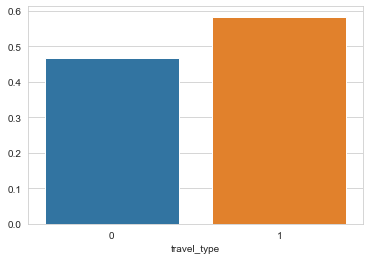

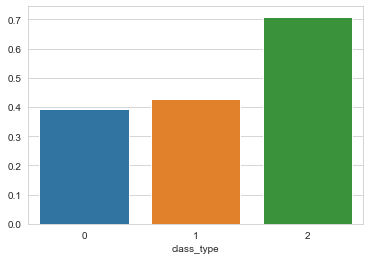

In [145]:
for i in df.columns[(df.max() < 5)].drop(labels='satisfaction'):
    temp = df.groupby(i).satisfaction.mean()
    x, y = temp.index, temp.values
    
    sns.barplot(x=x, y=y)
    plt.show()

Женщины, лояльные клиенты, пассажиры бизнес-класса в среднем чаще остаются довольны полетом, в то время как пассажиры в командировках чаще бывают неудовлетворены.

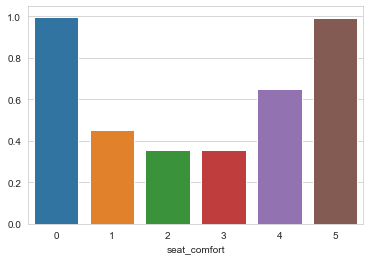

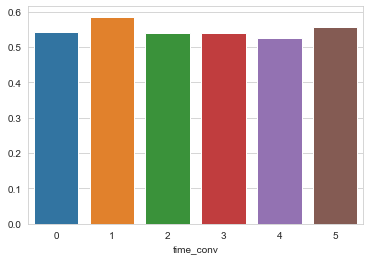

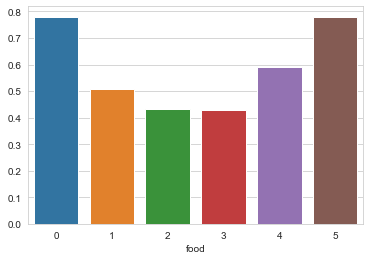

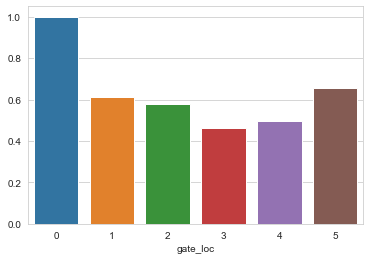

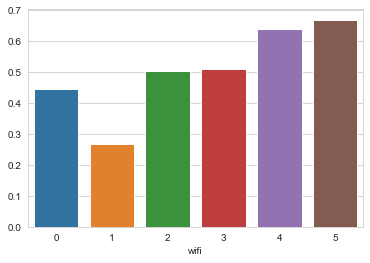

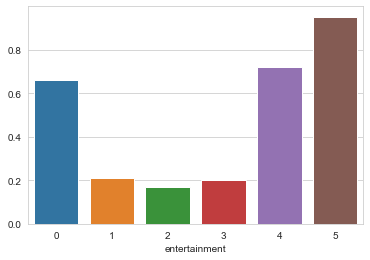

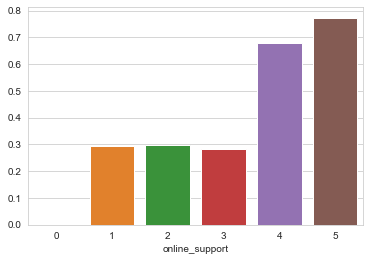

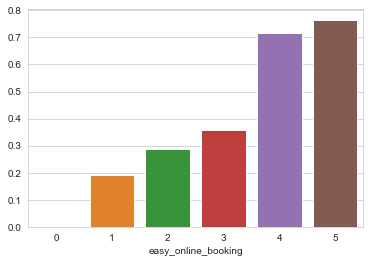

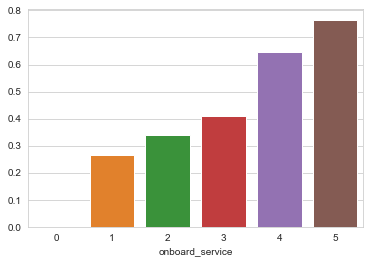

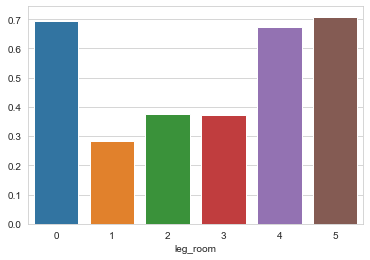

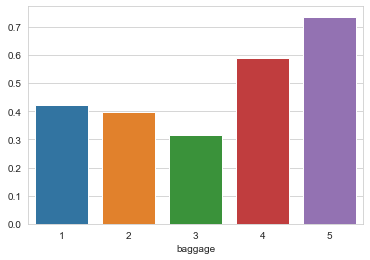

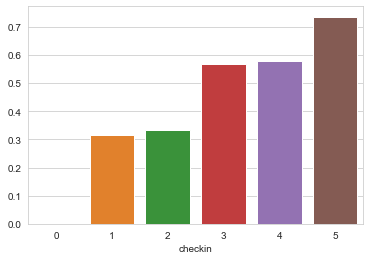

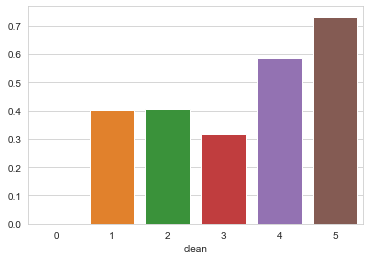

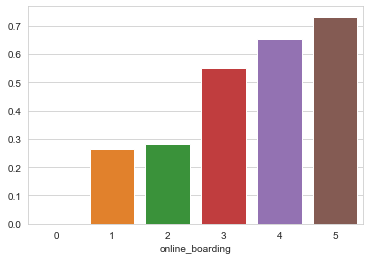

In [146]:
for i in df.columns[(df.max() == 5)]:
    temp = df.groupby(i).satisfaction.mean()
    x, y = temp.index, temp.values
    
    sns.barplot(x=x, y=y)
    plt.show()

Значение некоторых переменных может принимать значение 0, если пользователь не поставил оценку определенному аспекту полета.
</br>Судя по графикам выше, в большинстве случаев это значит отсутствие недовольства.

Также построим распределение количественных переменных в разбивке по удовлетворенности клиента.

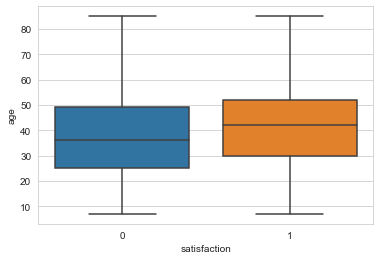

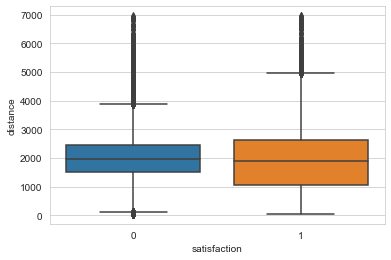

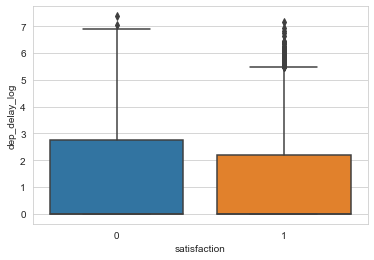

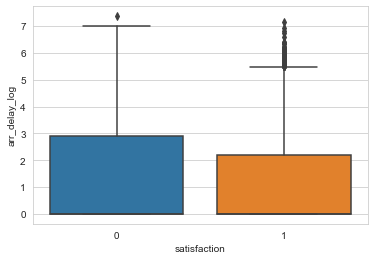

In [147]:
for i in df.columns[(df.max() > 5)].drop(labels=['dep_delay', 'arr_delay']):
    sns.boxplot(data=df, x='satisfaction', y=i)
    plt.show()

Довольные клиенты в среднем старше недовольных, дистанция полета слабо влияет на удовлетворенность.
</br>Задержки отправления и прибытия могут влиять на удовлетворенность, однако в большинстве случаев полет проходит по расписанию.

Посмотрим, как переменные коррелируют между собой.

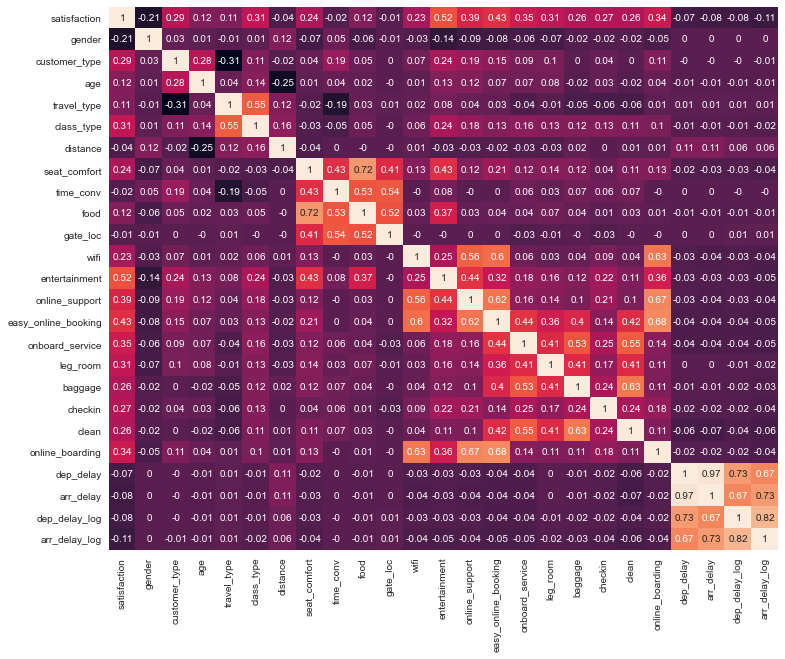

In [149]:
matrix = df.corr().round(2)
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cbar=False, annot=True)
plt.show()

Целевая переменная сильнее всего коррелирует с полом, типом клиента (лояльный или нет), классом и рядом оценок от пользователя.
</br>Оценки, в свою очередь, сильно коррелируют между собой, что нужно учитывать при построении регресии.

### Статистические критерии

В начале работы мы выдвинули гипотезу о том, что взрослые клиенты чаще оказываются недовольны полетом.
</br>Тем не менее, среднее значения возраста среди довольных клиентов было выше.
</br>Попробуем проверить этот факт с помощью Т-критерия - сравним средний возраст довольных и недовольных клиентов.
</br>Распределение возрастов в датасете близко к нормальному, поэтому мы можем применить Т-критерий, который является параметрическим.

In [107]:
a = df.query('satisfaction == 1').age
b = df.query('satisfaction == 0').age
print(a.mean())
print(b.mean())

ttest(a, b)

41.04960356649079
37.46837300571624


Ttest_indResult(statistic=42.72778185540331, pvalue=0.0)

Т-критерий показывает, что при имеющихся объемах выборок разница средних возрастов значима.

Также попробуем сравнить распределения задержки вылета в зависимости от значения целевой переменной. Задержка вылета не распределена нормально, поэтому используем непараметрический критерий Колмогорова-Смирнова.

In [283]:
a = df.query('satisfaction == 0').dep_delay
b = df.query('satisfaction == 1').dep_delay
print(a.mean())
print(b.mean())

kstest(a, b)

17.728777408070982
12.09239299116842


KstestResult(statistic=0.06525629590710613, pvalue=3.2333463115936797e-119)

Значение P-value близко к нулю, следовательно гипотеза о равенстве распределений может быть отвергнута.

Для сравнения проведем такой же тест, но разбив наблюдения по переменной gender. Очевидно, что значимой разницы между распределениями быть не должно.

In [284]:
a = df.query('gender == 0').dep_delay
b = df.query('gender == 1').dep_delay
print(a.mean())
print(b.mean())

kstest(a, b)

14.527129659224084
14.763138091057318


KstestResult(statistic=0.0024582613406376463, pvalue=0.9894206238216261)

Значение P-value близко к 1, следовательно мы можем принять гипотезу о равенстве распределений.

### Линейная регрессия

В рамках данного исследования применимость линейной регрессии ограничена, так как целевая переменная является бинарной, а задача классификации лучше решается логистической регрессией. Тем не менее, для тренировки попробуем предсказать возраст пассажира, используя 4 переменных, которые наиболее коррелируют с возрастом.

Разделим выборку на контроль и тест, обучим модель, предскажем значения и оценим качество с помощью средней абсолютной ошибки (MAE).

In [286]:
X = df.loc[:, ['customer_type', 'distance', 'entertainment', 'satisfaction']]
y = df.age

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [287]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [290]:
pred = model.predict(X_train)
print(y.mean())
print('MAE', mean_absolute_error(y_train, pred))

39.42876118838185
MAE 11.166369177248885


In [ ]:
Значение MAE получилось равным ~11.2, то есть в среднем наше предсказание ошибается на 11 лет. Тем не менее, мы использовали 

### Логистическая регрессия

Попробуем построить логистическую регрессию для предсказания вероятности того, что клиент останется доволен полётом.
</br>Возьмем 9 переменных - пол, возраст, тип клиента, класс, расстояние полета, логарифм задержки вылета, а также оценки комфортности сидения, развлечений и сервиса на борту.
</br>20% датасета выделим в тест.

In [225]:
X = df.loc[:, ['gender', 'age', 'customer_type', 'class_type', 'seat_comfort', 'entertainment', 'onboard_service', 'dep_delay_log', 'distance']]
y = df.satisfaction

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Обучим модель, предскажем целевую переменную для тестового датасета и оценим качество модели.

In [226]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [227]:
pred = model.predict(X_train)
print('Accuracy:', accuracy_score(y_train, pred))
print('Precision:', precision_score(y_train, pred))
print('Recall:', recall_score(y_train, pred))
print('ROC AUC:', roc_auc_score(y_train, pred))

Accuracy: 0.8098446746276149
Precision: 0.8127986174646742
Recall: 0.8472501854402882
ROC AUC: 0.8059999516636577


In [228]:
pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('ROC AUC:', roc_auc_score(y_test, pred))

Accuracy: 0.8095991968491776
Precision: 0.814637436762226
Recall: 0.8469144460028051
ROC AUC: 0.8053957004030179


Модель неплохо показала себя как на обучающей, так и на тестовой выборке.
</br>Посмотрим на коэффициенты регрессии.

In [229]:
for i in range(len(X.columns)):
    print(X.columns[i], model.coef_[0][i])

gender -0.9109598810658248
age -0.006334197148018333
customer_type 1.4951087363421094
class_type 0.5625562940186078
seat_comfort 0.12124488188081464
entertainment 0.7644541016990035
onboard_service 0.5668051321670327
dep_delay_log -0.09659836731198296
distance -0.00010046593483852444


Согласно коэффициентам регрессии, вероятность того, что клиент будет удовлетоворен полетом, уменьшается:
- если пассажир - мужчина
- с увеличением возраста (-0.63% за каждый год)
- с увеличением задержки вылета (-9.7% за каждую минуту)
- с увеличением расстояния (-0.01% за каждый километр)

И увеличивается:
- если клиент - лояльный
- с улучшением класса
- с увеличением оценки за удобство сидения (+12.1% за каждый балл)
- с увеличением оценки за развлечения (+76.4% за каждый балл)
- с увеличением оценки за обслуживание на борту (+56.3% за каждый балл)

В дальнейшем модель можно улучшить и добиться более высокого качества, например:
- Привести оценки от пассажира в бинарный формат, где 0 - плохая оценка (1-3), а 1 - хорошая оценка (4-5, сюда же можно попробовать отнести 0)
- Поработать над нормализацией распределений (расстояние, задержка полета)
- Опробовать различные комбинации переменных

### Random Forest

Попробуем предсказать целевую переменную с помощью модели RandomForestClassifier.
</br>Случайный лес лучше справляется с поиском нелинейных зависимостей и должен показать более высокую точность, чем логистическая регрессия.
</br>Обучим и протестируем модель на тех же данных, что использовали для линейной регрессии.
</br>Для простоты используем стандартные гиперпараметры модели.

In [233]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [234]:
pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('ROC AUC:', roc_auc_score(y_test, pred))

Accuracy: 0.9081396246814426
Precision: 0.9180800900837497
Recall: 0.914796633941094
ROC AUC: 0.9073897244288731


Случайный лес значительно лучше справился с предсказанием целевой переменной.

In [240]:
for i in range(len(X.columns)):
    print(X.columns[i], model.feature_importances_[i])

gender 0.0337991702723929
age 0.0949763040514457
customer_type 0.04410740797128716
class_type 0.06419539349454455
seat_comfort 0.1884889824492358
entertainment 0.2988343178055044
onboard_service 0.0971450703951077
dep_delay_log 0.046795607808537885
distance 0.13165774575194386


Наиболее важными переменными для модели оказались: развлечения, комфортность сидения, расстояние полета. Сюда же можно отнести обслуживание на борту и возраст.
</br>Пол, тип клиента, задержка вылета и класс оказались менее важными.

## Выводы
1. **Продолжительность полета отрицательно влияет на удовлетоворенность клиентов.**
    </br>Да, вероятность недовольства клиента пропорциональна расстоянию полета.
2. **Гендерная принадлежность в среднем не влияет на удовлетворенность клиента полетом.**
    </br>Скорее нет. При построеннии логистической регрессии эта переменная получила высокий коэффициент,
    </br>однако это могло быть вызвано неучтенной мультиколлинеарностью, так как при построении случайного леса вклад пола был мал.
3. **Лояльные клиенты чаще ставят высокие оценки и остаются удовлетворены полетом в целом.**
    </br>Аналогично предыдущему пункту - высокий коэффициент в регрессии и низкий эффект в случайном лесе.
4. **Пассажиры бизнес-класса чаще остаются удовлетворены полетом.**
    </br>Аналогично пунктам 2 и 3.
5. **Взрослые пассажиры чаще бывают недовольны полетом, чем молодые.**
    </br>Коэффициент при переменной в логистической регрессии был отрицательным, а важность при построении случайного леса высокой.
    </br>Можно сказать, что возраст можно использовать для предсказания удовлетворенности пассажира. Тем не менее, зависимость может быть нелинейной.
6. **Удобство кресла и развлечения в полете положительно влияют на удовлеторенность полетом.**
    </br>Да, обе модели свидетельствуют о большом значении этих переменных (особенно развлечений).